#재방문률과 성장률, 일 별 수익 사이의 관계

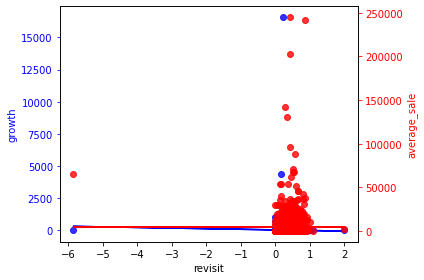

'\n결과 그래프를 보면 재방문률이 높아질수록 성장률은 증가하지만 일 별 수익은 감소하는 경향을 가진 것을 볼 수 있습니다.\n'

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np

file_dir = '/content/drive/MyDrive/kaggle-study/4/data/'
file_name = 'train.csv'

#데이터 불러와서 환불 처리 후 리스트에 저장하기

f = open(file_dir + file_name,'r',encoding='utf-8')
rdr = csv.reader(f)
table = []
linenum = -1

datanum = [0]*1800

totalsale = [0]*1800

for line in rdr:
    # line {0: store_id, 1: date, 2: time, 3: card_id, 4: amount, 5: installment, 6: days_of_week, 7: holyday}
    if line[0] != 'store_id' and line[4] != 0:
        line.append(line[1]) # 기존 date 뒤에 추가
        line[1] = (int(line[1][0:4])-2016)*12 + int(line[1][5:7]) - 8
        #거래 일자를월 단위로 바꿉니다.
        line.pop(2)
        line.pop(4)
        line.pop(4)
        line.pop(4)
        #거래 시간, 할부 개월 수, 요일, 공휴일 여부는 사용하지 않으므로 삭제했습니다
        # line {0: store_id, 1: monte(위에서 변환한거), 2: card_id, 3: amount, 4: date}
        
        apnd = 0
        
        if int(line[3]) < 0:
            '''
            환불이 일어났을 경우 같은 hash값을 갖는 카드로 같은 금액을 결제했을 때
            그 기록을 함께 삭제하고 그런 상황이 없을 때는 환불 관련 기록만 삭제합니다.
            '''
            hchk = 0
            
            # 맨 처음부터 현재 행까지 확인
            for i in range(linenum+1):
                
                if table[linenum-i][0] == line[0] and table[linenum-i][2] == line[2] and int(table[linenum-i][3]) + int(line[3]) == 0:
                    table.pop(linenum-i-1)
                    linenum -= 2
                    datanum[int(line[0])] -= 2
                    hchk = 1
                    apnd = 1
                    break
                
            if hchk == 0: # 이전 행 삭제 이뤄졌었다면
                apnd = 1
                linenum -= 1
                datanum[int(line[0])] -= 1
                
        if apnd == 1:
            apnd = 0
            
        else:
            table.append(line)
            datanum[int(line[0])] += 1
            #해당 상점의 거래 횟수를 기록합니다.
        linenum += 1

f.close()

#사용할 데이터 모으기

data = []
totalsale = [0]*1800

monthsale = [[0,0] for i in range(1800)]

n = 0

for i in table:
    n+=1
    if datanum[int(i[0])] <= 7000 and datanum[int(i[0])] <= 15000 :
        #데이터의 개수가 7000개 이상 15000개 미만인 상점에 대해서만 데이터를 사용합니다.
        data.append(i)
        totalsale[int(i[0])] += int(i[3])
        monthsale[int(i[0])][i[1]//12] += int(i[3])
        #월별 수익과 전체 수익을 기록합니다.
        
#성장률 구하기

growth = []

for i in monthsale:
    s = 0
    n=0
    for j in range(1):
        if i[j] != 0:
            s += 1+(i[j+1]-i[j])/i[j]
            #윌별 성장률을 이 식을 통해 구했습니다.
            n += 1
    if n == 0:
        s = 0
    else:
        s /= n
    growth.append(s)
    #월별 성장률을 구해서 그 평균을 이용했습니다.
    
#재방문률과 영업 일수 구하기

customer = []
date = []
revisit = [0]*1800
datenum = [0]*1800

avesale = [0]*1800

pastid = 0
for i in data:

    if pastid != int(i[0]):
        customer = []
        date = []
        
    if i[2] in customer:
        revisit[int(i[0])] += 1

    else:
        customer.append(i[2])
        
    if i[4] in date:
        datenum[int(i[0])] += 1

    else:
        date.append(i[4])
        
    pastid = int(i[0])

for i in range(1800):
    
    if datanum[i] != 0:
        revisit[i] = revisit[i]/datanum[i]
        #전체 상점 결제 횟수 중 재방문의 횟수를 구합니다.

    if datenum[i] != 0:
        avesale[i] = totalsale[i]/datenum[i]
        #전체 수익을 영업 일수로 나누어 일별 수익을 구합니다.
        
#총 수익이 0이거나 성장률이 0이하인 이상값들을 제거합니다.

i = 0
for j in range(1800):
    
    if totalsale[i] == 0 or growth[i] <= 0:
        totalsale.pop(i)
        avesale.pop(i)
        growth.pop(i)
        revisit.pop(i)
        i -= 1
        
    i += 1
    
#그래프 그리기

fig, ax1 = plt.subplots()
ax1.scatter(revisit, growth, c='blue', alpha=0.8)
ax1.set_xlabel('revisit')


ax1.set_ylabel('growth', color='b')
ax1.tick_params('y', colors='b')

z1 = np.polyfit(revisit, growth, 1)
p1 = np.poly1d(z1)
ax1.plot(revisit, p1(revisit), color='b')

ax2 = ax1.twinx()
ax2.scatter(revisit, avesale, c='red', alpha=0.8)
ax2.set_ylabel('average_sale', color='r')
ax2.tick_params('y', colors='r')

z2 = np.polyfit(revisit, avesale, 1)
p2 = np.poly1d(z2)
ax2.plot(revisit, p2(revisit), color='r')

fig.tight_layout()
plt.show()

'''
결과 그래프를 보면 재방문률이 높아질수록 성장률은 증가하지만 일 별 수익은 감소하는 경향을 가진 것을 볼 수 있습니다.
'''